In [11]:
from gerrychain import Graph, Election, updaters, Partition, constraints, MarkovChain
from gerrychain.updaters import cut_edges, Tally, DataTally
from gerrychain.proposals import recom
from gerrychain.tree import recursive_tree_part
from gerrychain.accept import always_accept
import numpy as np
import operator
from functools import partial
import matplotlib
import matplotlib.pyplot as plt
import geopandas as gpd
import math, os
import pickle
import sys
import networkx as nx
import random
from collections import defaultdict, OrderedDict

In [13]:
gdf = gpd.read_file('states/shapefiles/PA_VTD_PLANS/PA_VTD_PLANS.shp')
graph = Graph.from_json('states/PA_VTD.json')
gdf = gdf.to_crs({"init":"epsg:2271"})

#add x,y coords for plotting dual graph
gdf['x_cord'] = gdf.centroid.x
gdf['y_cord'] = gdf.centroid.y
gdf = gdf.reset_index()
node_pos = {}

for idx, row in gdf.iterrows():
    node_pos[row['index']] = (row['x_cord'], row['y_cord'])

/Users/jackgibson/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [14]:
# helper functions 
def adjacency_graph_cut_edges(partition):
    """Returns the dual graph of a districting plan
    """
    edges = set([(partition.assignment[x], partition.assignment[y]) for x, y in partition['cut_edges']])
    adjacency_graph = nx.Graph()
    adjacency_graph.add_nodes_from(list(partition.partitions.keys()))
    adjacency_graph.add_edges_from(list(edges))
    return adjacency_graph

def relabel_by_dem_vote_share(partition, election):
    """Renumbers districts by DEM vote share, 0-indexed
    """
    dem_percent = election.percents('Democratic')
    unranked_to_ranked = sorted([(list(partition.partitions.keys())[x], dem_percent[x])
                                  for x in range(0, len(partition))],
                                  key=operator.itemgetter(1))
    unranked_to_ranked_list = [x[0] for x in unranked_to_ranked]
    unranked_to_ranked = {unranked_to_ranked[x][0]:x for x in range(0, len(partition))}
    newpartition = partition(partition.graph, {x:unranked_to_ranked[partition.assignment[x]] for x in partition.graph.nodes}, partition.updaters)
    return newpartition

def get_splits(districts, neighborhoods):
    '''
    Takes in partition, returns a list of split neighborhoods 
    '''
    
    splits = []

    districts = districts.to_dict()
    for neigborhood in neighborhoods:
        curr_dist = set()
        for node in neigborhood:
            curr_dist.add(districts[node])
        if len(curr_dist) != 1:
            splits.append(neigborhood)

    return splits


def get_people_split(graph, districts, neighborhoods):
    '''
    Returns the fraction of largest group split of in all split neighborhoods
    and the percentage of fractured groups out of the states
    '''

    numerator = []
    denominator = []
    total_neighbors = 0 
    split_neighborhoods = get_splits(districts, neighborhoods)

    for neighborhood in neighborhoods:
        for node in neighborhood:
            total_neighbors += graph.nodes[node]['TOTPOP']
        if neighborhood in split_neighborhoods:
            split_subsets = defaultdict(0)
            for node in neighborhood:
                dist_assignment = districts[node]
                split_subsets[dist_assignment] += graph.nodes[node]['TOTPOP']
            max_pop = max(split_subsets.values(), key=lambda x: int(x))
            nhood_total = sum(split_subsets.values()) - max_pop
            denominator.append(sum(split_subsets.values()))
            numerator.append(nhood_total) 
    
    n_percents = np.array(numerator)/np.array(denominator)
    
    state_percent = sum(numerator)/total_neighbors
    
    return n_percents, state_percent

def random_k_neighbors(graph, r, k, weights):
    '''
    Returns k-sized neighborhoods for all nodes in a graph
    '''
    rand_nodes = random.choices(list(graph.nodes), weights=weights, k=k)
    
    neighbors = []
    for node in rand_nodes:
        nh = nx.ego_graph(graph, node, radius=r)
        neighbors.append(nh.nodes)

    return neighbors

def safe_seats(partition):
    '''
    Counts the number of 'safe-seats' won by a partition
    '''
    election = partition.updaters['election']
    threshold = partition.updaters['threshold']
    tilted_party = partition.updaters['party']
    
    percents = partition[election].percents(tilted_party)

    num_seats = 0
    for percent in percents:
        if percent > threshold:
            num_seats += 1

    return num_seats


def tilted_districts(partition: Partition) -> bool:
    '''
    Acceptance function that keeps plans that 
    '''
    if partition.parent is not None:
        if partition.safe_seats >= partition.parent.safe_seats:
            return True
    
    return random.uniform(0,1) <= math.e**-2

# lambda to generate list of random colors for plotting
get_colors = lambda n: ["#%06x" % random.randint(0, 0xFFFFFF) for _ in range(n)]

In [ ]:
# Weight by other factors besides total population
# BVAP
# Aggregate POCVAP 


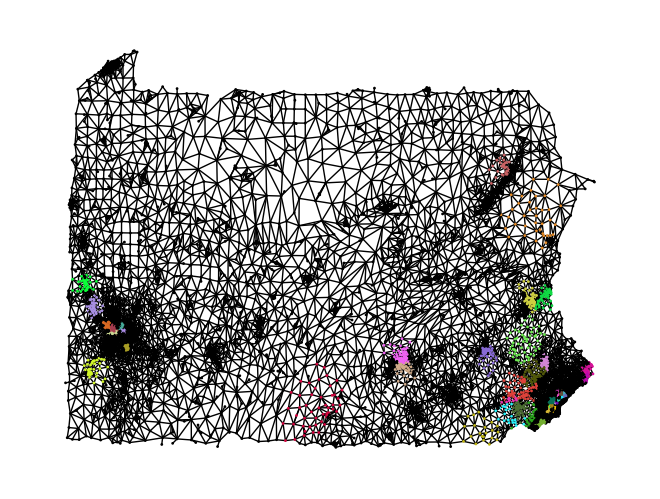

In [15]:
weights = [graph.nodes[node]['BVAP'] for node in graph.nodes]

colors = get_colors(150)
color_map = {}

test_nh = random_k_neighbors(graph, 3, 50, weights)

for nodes, color in zip(test_nh, colors):
    for node in nodes:
        color_map[node] = color 

for node in graph.nodes:
    if node not in color_map:
        color_map[node] = 'black'

ordered_map = OrderedDict(sorted(color_map.items()))
nx.draw(graph, node_pos, node_size=0.95, node_color=list(ordered_map.values())) 

In [41]:
# Set variables 
election_names = ["PRES16", "SEN16", "ATG12", "GOV14", "GOV10", "PRES12", "SEN10", "ATG16", "SEN12"]

election_columns = [
    ["T16PRESD", "T16PRESR"],
    ["T16SEND", "T16SENR"],
    ["ATG12D", "ATG12R"],
    ["F2014GOVD", "F2014GOVR"],
    ["GOV10D", "GOV10R"],
    ["PRES12D", "PRES12R"],
    ["SEN10D", "SEN10R"],
    ["T16ATGD", "T16ATGR"],
    ["USS12D", "USS12R"]    
] #DEM, REP

pop_tol = 0.02
pop_col = "TOTPOP"
num_districts = 50

INTERVAL = 10
pop_weights = [graph.nodes[node]['BVAP'] for node in graph.nodes]
# set neighborhoods
neighborhoods = random_k_neighbors(graph, 2, 50, pop_weights)

<AxesSubplot:>

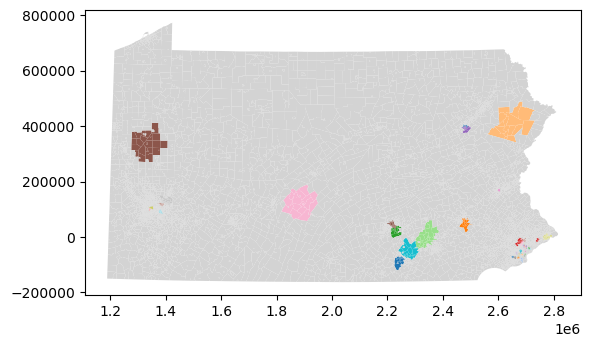

In [43]:
# Draw neighborhoods 
neigh_map = {}
for id, neigh in enumerate(neighborhoods):
    for node in neigh:
        neigh_map[node] = id

# gdf['districts'] = gdf['index'].map(initial_partition.assignment.to_dict())
gdf['neighborhoods'] = gdf['index'].map(neigh_map)
gdf.plot(column='neighborhoods', cmap='tab20', missing_kwds={'color': 'lightgray'})
# gdf.plot(column='districts', cmap='tab20')

In [30]:
for n in graph.nodes: #fix NaN
    for i in range(len(election_columns)):
        for j in [0,1]:
            if math.isnan(graph.nodes[n][election_columns[i][j]]):
                graph.nodes[n][election_columns[i][j]] = 0
                print("Fixed NaN in ", election_columns[i][j])

total_population = sum([graph.nodes[n][pop_col] for n in graph.nodes()])

In [ ]:
## Generate tilted ensembles 
total_results = {}
total_splits = {}
all_dists = {}

for tilted_party in ['Democratic', 'Republican']:
    # setup recom chain
    steps = 10000

    # for tilted ensembles
    election = 'PRES16'
    threshold = 0.53

    pop_target = total_population/num_districts
    myproposal = partial(recom, pop_col=pop_col, pop_target=pop_target, epsilon=pop_tol, node_repeats=2)

    #updaters
    myupdaters = {
        "population": updaters.Tally(pop_col, alias="population"),
        "safe_seats": safe_seats,
        'threshold': threshold,
        'party': tilted_party,
        'election': election
    }

    elections = [
        Election(
            election_names[i],
            {"Democratic": election_columns[i][0], "Republican": election_columns[i][1]},
        )
        for i in range(len(election_names))
    ]
    election_updaters = {election.name: election for election in elections}
    myupdaters.update(election_updaters)

    first = recursive_tree_part(graph, range(num_districts), total_population/num_districts, pop_col, pop_tol)
    initial_partition = Partition(graph, first, myupdaters)

    myconstraints = [
            constraints.within_percent_of_ideal_population(initial_partition, pop_tol)
        ]

    print(initial_partition.updaters)
    chain = MarkovChain(
            proposal=myproposal,
            constraints=myconstraints,
            accept=tilted_districts,
            initial_state=initial_partition,
            total_steps=steps
        )

    #run recom 
    election_data = {e: [] for e in election_names}
    split_lst = []
    districts = []

    print(f'Generating {tilted_party}-favoring plans')
    for index, step in enumerate(chain):
        if index%INTERVAL == 0:
            split_lst.append(get_splits(step.assignment, neighborhoods))
            districts.append(step.assignment)
            for e in election_names:
                election_data[e].append(step[e].seats('Democratic'))
                

    total_results[tilted_party] = election_data
    total_splits[tilted_party] = split_lst
    all_dists[tilted_party] = districts
    print(f"Done with {tilted_party}-favoring plans")

In [6]:
#optional cell to pickle ensemble data 
os.makedirs('tilted_ensembles', exist_ok=True)
pickle.dump(total_results, open("tilted_ensembles/election_data.p", "wb"))
pickle.dump(total_splits, open("tilted_ensembles/splits.p", "wb"))
pickle.dump(neighborhoods, open("tilted_ensembles/neighborhoods.p", "wb"))
pickle.dump(all_dists, open("tilted_ensembles/district_plans.p", "wb"))

In [ ]:
neigh_map = {}
for id, neigh in enumerate(test_nh):
    for node in neigh:
        neigh_map[node] = id

<AxesSubplot:>

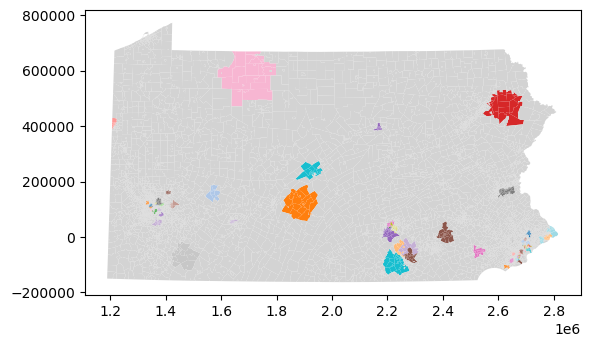

In [29]:
# Draw neighborhoods 
neigh_map = {}
for id, neigh in enumerate(neighborhoods):
    for node in neigh:
        neigh_map[node] = id

# gdf['districts'] = gdf['index'].map(initial_partition.assignment.to_dict())
gdf['neighborhoods'] = gdf['index'].map(neigh_map)
gdf.plot(column='neighborhoods', cmap='tab20', missing_kwds={'color': 'lightgray'})
# gdf.plot(column='districts', cmap='tab20')

In [ ]:
election_data = {e: [] for e in election_names}
parts = []
split_lst = []
INTERVAL = 10

nbs = random_k_neighbors(graph, 2, 500, pop_weights)

for index, step in enumerate(chain):
    if index%INTERVAL == 0:
        # split_lst.append(get_splits(step.assignment, nbs))
        for e in election_names:
            election_data[e].append(step[e].seats('Democratic'))
            #appends node to dictionary mapping 

<AxesSubplot:ylabel='Count'>

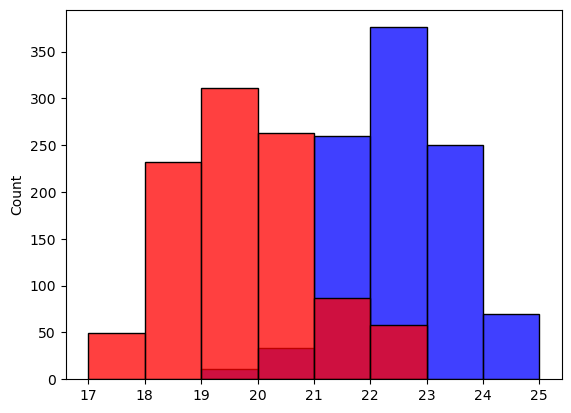

In [18]:
import seaborn as sns
sns.histplot(total_results['Democratic']['PRES16'], color='blue', binwidth=(1))   
sns.histplot(total_results['Republican']['PRES16'], color='red', binwidth=(1))

In [ ]:
import pandas as pd
num_splits = {}
for idx, i in enumerate(total_splits['Democratic']):
    num_splits[idx] = len(split_lst[idx])

num_df = pd.DataFrame({'neighborhood' : list(num_splits.keys()), 'splits' : list(num_splits.values())})
num_df[num_df['splits'] == num_df['splits'].min()]

for election in election_names:
    num_df[election] = election_data[election]

In [ ]:
num_df[num_df['splits']==num_df['splits'].max()]
num_df[num_df['splits']==num_df['splits'].min()]

In [ ]:
# quick exploration of any correlation
import scipy.stats as st
corr = {}

for election in election_names:
    corr[election] = st.pearsonr(num_df['splits'], num_df[election])

corr

<AxesSubplot:xlabel='splits'>

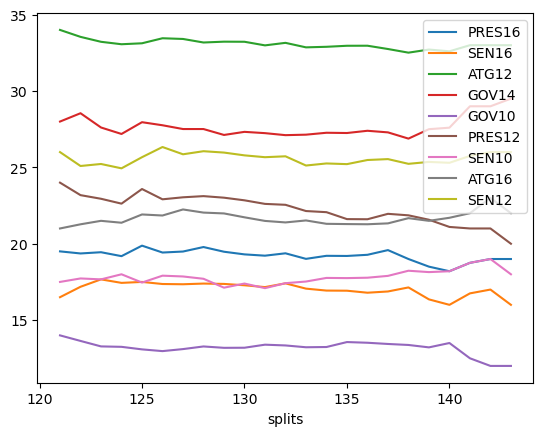

In [12]:
by_splits = num_df.groupby('splits').mean()
to_graph = by_splits[election_names]
to_graph.plot.line()

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
save = 10

#generate aggregated splits
agg_dict = {}
for index, splits in enumerate(split_lst):
    for neighborhood in splits:
        # color = get_colors(1)[0]
        for node in neighborhood:
            agg_dict[node] = 'limegreen'

    for node in graph.nodes:
        if node not in agg_dict:
            agg_dict[node] = 'black'

    ordered_map = OrderedDict(sorted(agg_dict.items()))

    if index%save == 0:
        test = plt.figure()
        nx.draw(graph, node_pos, node_size=0.95, node_color=list(ordered_map.values()))
        test.savefig(f'pa_outputs2/graph_{index}.png')

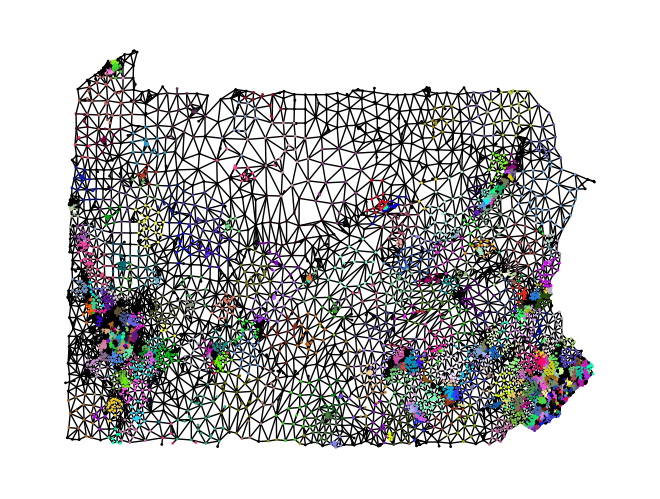

In [ ]:
colors = get_colors(500)
color_map = {}

for nodes, color in zip(nbs, colors):
    for node in nodes:
        color_map[node] = color 


for node in graph.nodes:
    if node not in color_map:
        color_map[node] = 'black'

ordered_map = OrderedDict(sorted(color_map.items()))
nx.draw(graph, node_pos, node_size=0.95, node_color=list(ordered_map.values()))